<a href="https://colab.research.google.com/github/antran28/Customer-Churn-Classification-Decision-Tree/blob/main/Customer_Churn_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import collections
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
import pydotplus  # pip install pydotplus
from sklearn.tree import export_graphviz

def tree_graph_to_png(tree, feature_names, png_file_to_save):
    # needs graphviz to be installed
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [3]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [4]:
df = pd.read_csv(DATA_PATH + "telecom_churn.csv")

In [5]:
df

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,Yes,No,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

**Slight preprocessing**

In [7]:
df['International plan']=df['International plan'].map({'Yes':1, 'No':0})
df['Voice mail plan']=df['Voice mail plan'].map({'Yes':1, 'No':0})

In [8]:
df['Churn'] = df['Churn'].astype('int')

In [9]:
df

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,0,1,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,0
3329,WV,68,415,0,0,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,0
3330,RI,28,510,0,0,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,0
3331,CT,184,510,1,0,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,0


**Save states as a Series and drop for now from the DataFrame**

In [10]:
states = df.pop('State')
states

0       KS
1       OH
2       NJ
3       OH
4       OK
        ..
3328    AZ
3329    WV
3330    RI
3331    CT
3332    TN
Name: State, Length: 3333, dtype: object

**Split the DataFrame into a matrix `X` and vector `y` which form the trainin set**

In [11]:
X, y = df.drop('Churn', axis=1), df['Churn']

In [12]:
df.drop(["Churn"], axis=1, inplace=True)

So, in summary, this code is splitting a DataFrame df into two separate parts:

X: This contains all the columns of df except for 'Churn'. It is often used as the feature matrix for a machine learning model, representing the input variables.

y: This contains the values of the 'Churn' column from df. It typically represents the target variable for a machine learning model, which is what you're trying to predict.

In [13]:
X.shape, y.shape

((3333, 18), (3333,))

In [14]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

Let’s allocate 70% of the set for training (X_train, y_train) and 30% for the hold-out set (X_holdout, y_holdout). The hold-out set will not be involved in tuning the parameters of the models. We’ll use it at the end, after tuning, to assess the quality of the resulting model.

In [15]:
X_train, X_holdout,  y_train, y_holdout = \
    train_test_split(X, y, test_size=.3, random_state=17)
X_train.shape, X_holdout.shape

((2333, 18), (1000, 18))

Here's what's happening:

**X and y**: These are typically your feature matrix (X) and target variable (y). X contains the input features or independent variables, and y contains the corresponding labels or dependent variable.

**train_test_split**: This is a function provided by libraries like Scikit-Learn in Python. It's used to split your dataset into two or more parts. In this case, you are splitting X and y into training and holdout sets.

**test_size=0.3**: This argument specifies the proportion of the data that should be allocated to the holdout set. In this case, it's set to 0.3, which means 30% of the data will be used as the holdout set, and the remaining 70% will be used as the training set. The choice of this proportion can vary depending on the specific problem and dataset.

**random_state=17**: This argument is used to set a random seed for the random number generator. Setting a random seed ensures that the split is reproducible. In other words, if you run this code multiple times with the same random seed (in this case, 17), you will get the same split each time. This is useful for reproducibility in your machine learning experiments.

After running this code, you will have the following variables:

X_train: This contains a subset of the features (X) that will be used for training your machine learning model.

y_train: This contains the corresponding labels (y) for the training data.

X_holdout: This contains a separate subset of the features (X) that will be used as a holdout set for evaluating your model.

y_holdout: This contains the corresponding labels (y) for the holdout data.

The reason for splitting the data into training and holdout sets is to assess how well your machine learning model generalizes to new, unseen data. You train your model on the training set and then evaluate its performance on the holdout set. This helps you estimate how well your model will perform on new, unseen data, and it can help you detect issues like overfitting (when the model performs well on the training data but poorly on new data).

In [16]:
from sklearn.tree import DecisionTreeClassifier

Let’s train 2 models: decision tree and k-NN. We do not know what parameters are good, so we will assume some random ones: a tree depth of 5.

**Decision Tree Classifier Model**

In [17]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)

In [18]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=17)

In [19]:
tree_graph_to_png(
    tree=tree,
    feature_names=X_train.columns,
    png_file_to_save="churn_decision_tree.png",
)

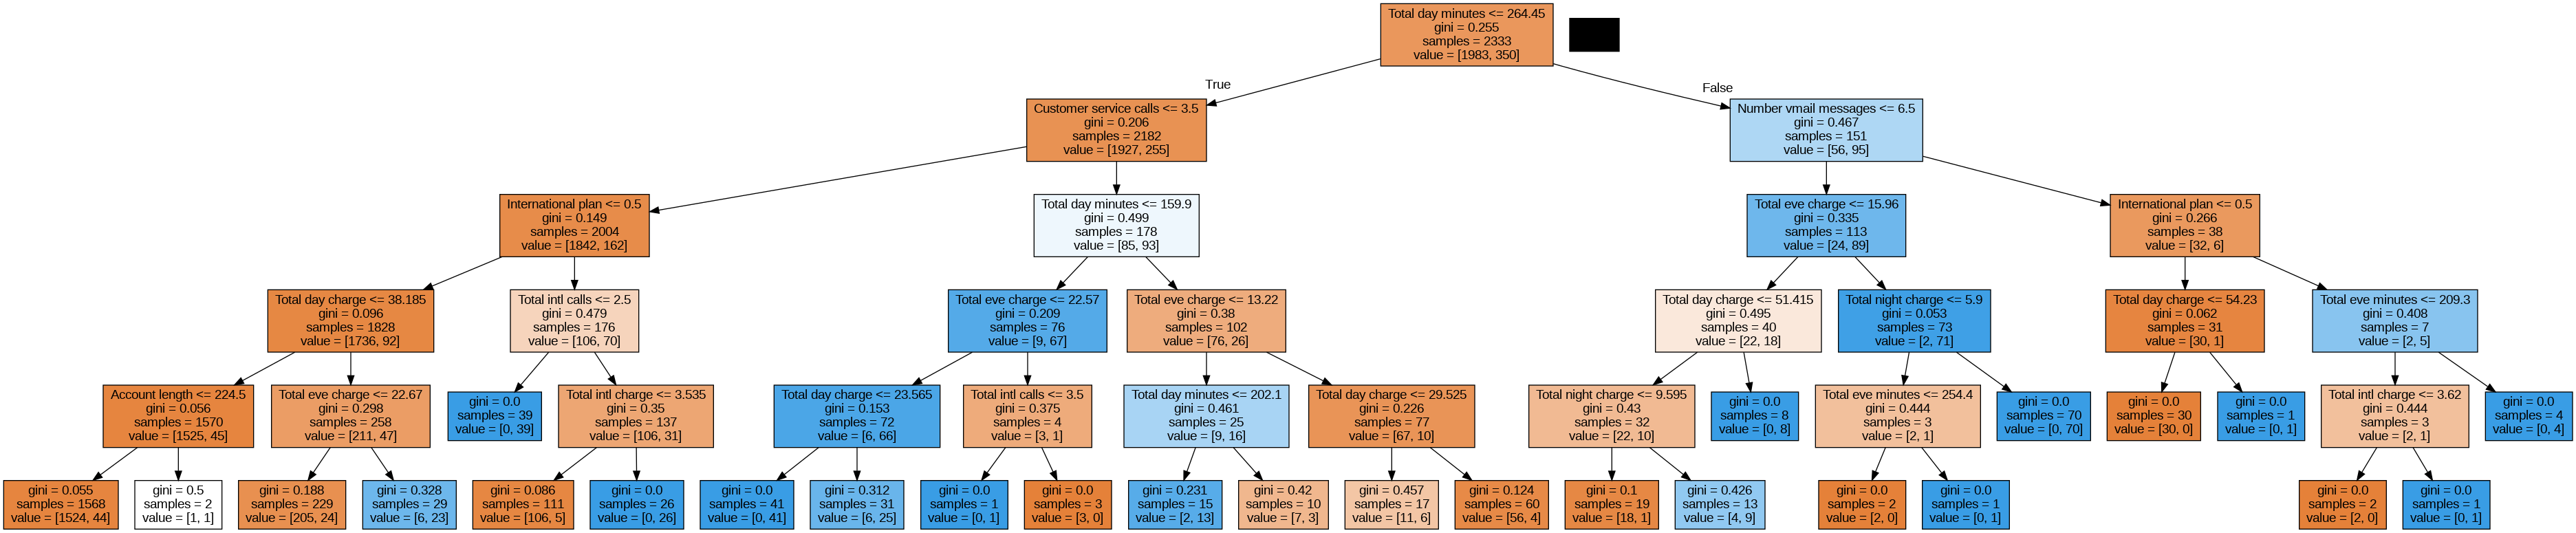

**Cross-validation - Hyperparameter Tunning**:
Let’s assess prediction quality on our hold-out set with a simple metric, the proportion of correct answers accuracy. The percentage of correct answers is about 94% decision tree. Note that this performance is achieved by using random parameters.

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
#Decision Tree
tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.94

Now, let’s identify the parameters for the tree using cross-validation. We’ll tune the maximum depth and the maximum number of features used at each split. Here is the essence of how the GridSearchCV works: for each unique pair of values of max_depth and max_features, compute model performance with 5-fold cross-validation, and then select the best combination of parameters.

In [22]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {"max_depth": range(1, 11), "max_features": range(4, 20)}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 20)},
             verbose=True)

In [23]:
tree_grid.best_params_

{'max_depth': 6, 'max_features': 17}

In [24]:
tree_grid.best_score_

0.94257014456259

In [25]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.948

In [26]:
tree_grid.best_estimator_

DecisionTreeClassifier(max_depth=6, max_features=17, random_state=17)

In [27]:
tree_graph_to_png(
    tree=tree_grid.best_estimator_,
    feature_names=df.columns,
    png_file_to_save="churn_decision_tree_turning.png",
)

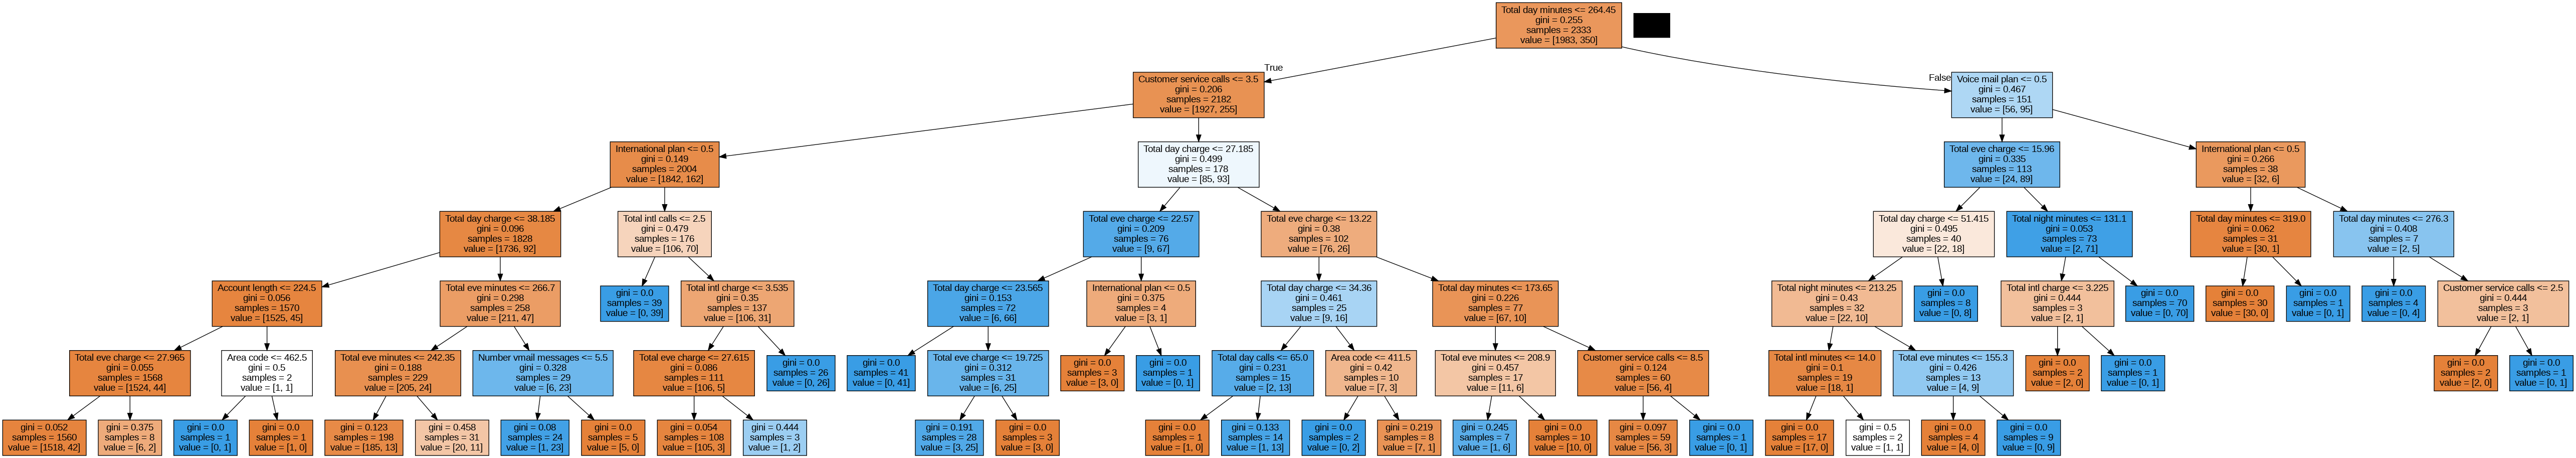